Import necessary libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import numpy as np
import matplotlib.pyplot as plt

Load Dataset (CIFAR-10 as an example)

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Convert labels to categorical

In [3]:
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Baseline Model (No Regularization)

In [4]:
def build_baseline_model():
    model = keras.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

L2 Regularization (Weight Decay): Adds penalty term λ||W||² to loss function

In [5]:
lambda_l2 = 0.001
def build_l2_model():
    model = keras.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', kernel_regularizer=regularizers.l2(lambda_l2), input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=regularizers.l2(lambda_l2)),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(lambda_l2)),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

Dropout Regularization: Drops neurons randomly during training to prevent overfitting

In [6]:
def build_dropout_model():
    model = keras.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),  # Dropout applied
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

Early Stopping: Stops training when validation loss stops improving

In [7]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

Data Augmentation: Generates new samples by transforming existing images

In [11]:
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

def build_augmented_model():
    model = build_baseline_model()
    return model

 Adding Noise to Inputs: Enhances robustness by making model handle slight perturbations

In [8]:
def add_noise(x):
    noise_factor = 0.1
    return x + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x.shape)

x_train_noisy = np.clip(add_noise(x_train), 0.0, 1.0)
x_test_noisy = np.clip(add_noise(x_test), 0.0, 1.0)

def build_noisy_model():
    model = build_baseline_model()
    return model

Ensemble Methods: Combining multiple models' predictions for better generalization

In [9]:
def ensemble_predict(models, x):
    predictions = np.array([model.predict(x) for model in models])
    return np.mean(predictions, axis=0)

Compile and Train a Model

In [12]:
models = {
    "Baseline": build_baseline_model(),
    "L2 Regularization": build_l2_model(),
    "Dropout": build_dropout_model(),
    "Augmentation": build_augmented_model(),
    "Noise Addition": build_noisy_model()
}

accuracies = {}

for name, model in models.items():
    print(f"Training {name} Model...")
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_test, y_test), callbacks=[early_stopping] if name == "Early Stopping" else [])
    models[name] = model
    accuracies[name] = max(history.history['val_accuracy'])

Training Baseline Model...
Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 62s 77ms/step - accuracy: 0.3840 - loss: 1.6869 - val_accuracy: 0.5737 - val_loss: 1.2211
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 81s 76ms/step - accuracy: 0.5872 - loss: 1.1686 - val_accuracy: 0.6345 - val_loss: 1.0537
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 56s 72ms/step - accuracy: 0.6421 - loss: 1.0272 - val_accuracy: 0.6474 - val_loss: 1.0135
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 83s 74ms/step - accuracy: 0.6890 - loss: 0.8989 - val_accuracy: 0.6723 - val_loss: 0.9520
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 83s 75ms/step - accuracy: 0.7110 - loss: 0.8290 - val_accuracy: 0.6775 - val_loss: 0.9243
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 57s 73ms/step - accuracy: 0.7371 - loss: 0.7536 - val_accuracy: 0.6932 - val_loss: 0.9080
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 59s 75ms/step - accuracy: 0.7590 - loss: 0.6956 - val_accuracy: 0.6893 - val_loss: 0.9338
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 81s 73ms/step - accurac

Evaluate Models

In [13]:
def evaluate_models(models):
    results = {}
    for name, model in models.items():
        loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
        results[name] = accuracy
        print(f"{name}: Test Accuracy = {accuracy:.4f}")
    return results

results = evaluate_models(models)

Baseline: Test Accuracy = 0.7053
L2 Regularization: Test Accuracy = 0.6838
Dropout: Test Accuracy = 0.6981
Augmentation: Test Accuracy = 0.7071
Noise Addition: Test Accuracy = 0.7079


Visualization

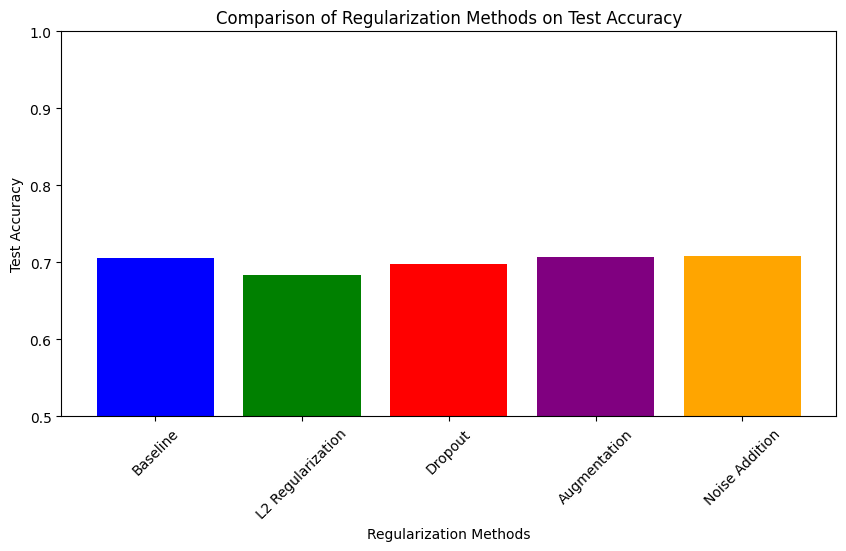

In [14]:
plt.figure(figsize=(10,5))
plt.bar(results.keys(), results.values(), color=['blue', 'green', 'red', 'purple', 'orange'])
plt.xlabel("Regularization Methods")
plt.ylabel("Test Accuracy")
plt.title("Comparison of Regularization Methods on Test Accuracy")
plt.xticks(rotation=45)
plt.ylim(0.5, 1.0)
plt.show()